In [1]:
import os
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch
from torch import nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import random
from collections import Counter
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('cuda' if torch.cuda.is_available() else 'cpu')

cuda


In [28]:
data_dir = "./data"

In [29]:
def load_image_paths_and_labels(data_dir):
    image_paths, labels = [], []
    for label, category in enumerate(os.listdir(data_dir)):
        category_path = os.path.join(data_dir, category)
        if not os.path.isdir(category_path):
            continue
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()
                image_paths.append(img_path)
                labels.append(label)
            except (UnidentifiedImageError, OSError):
                pass
    return image_paths, labels

In [30]:
image_paths, labels = load_image_paths_and_labels(data_dir)

In [31]:
categories = [category for category in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, category))]

In [32]:
counts = Counter(labels)
print("Category distribution:", dict(counts))

Category distribution: {0: 997, 1: 1478, 2: 1000, 3: 152, 4: 1000, 5: 2127, 6: 1000, 7: 1591, 8: 1909, 9: 952, 10: 1771, 11: 1676, 12: 1404, 13: 373, 14: 3208}


In [33]:
sizes = [Image.open(p).size for p in image_paths]
widths, heights = zip(*sizes)
print(f"Image Sizes: Min ({min(widths)}x{min(heights)}), Max ({max(widths)}x{max(heights)}), Avg ({np.mean(widths):.1f}x{np.mean(heights):.1f})")

Image Sizes: Min (256x256), Max (256x256), Avg (256.0x256.0)


Sample Images:


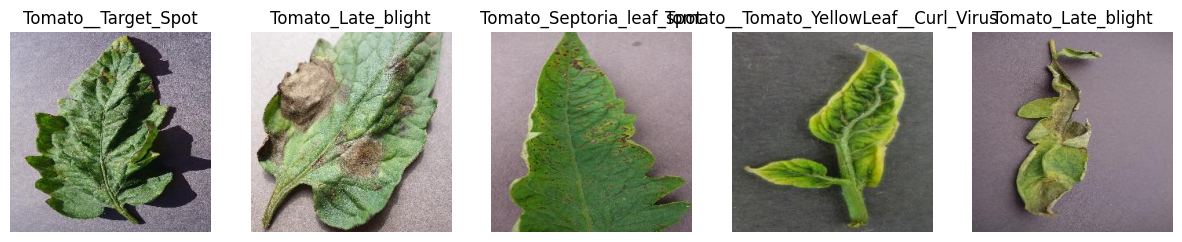

In [34]:
print("Sample Images:")
plt.figure(figsize=(15, 5))
for i in range(5):  
    idx = random.randint(0, len(image_paths) - 1)
    img = Image.open(image_paths[idx])
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(categories[labels[idx]])
    plt.axis("off")
plt.show()


In [35]:
image_paths, labels = load_image_paths_and_labels(data_dir)
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [36]:
class PlantDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_loader = DataLoader(PlantDataset(X_train, y_train, transform), batch_size=32, shuffle=True)
test_loader = DataLoader(PlantDataset(X_test, y_test, transform), batch_size=32, shuffle=False)


In [37]:
baseline_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
baseline_model.fc = nn.Linear(baseline_model.fc.in_features, len(set(labels)))
baseline_model = baseline_model.to(device)

In [38]:
class EnhancedModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super().__init__()
        self.base = nn.Sequential(*list(base_model.children())[:-1]) 
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(base_model.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.base(x)
        return self.fc(x)

enhanced_model = EnhancedModel(baseline_model, len(set(labels))).to(device)

In [39]:
def train_model(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [40]:
def validate_model(model, loader, criterion):
    model.eval()
    total_loss, y_true, y_pred = 0, [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            total_loss += criterion(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    metrics = {
        "loss": total_loss / len(loader),
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, average="weighted"),
        "precision": precision_score(y_true, y_pred, average="weighted"),
        "recall": recall_score(y_true, y_pred, average="weighted")
    }
    return metrics

In [41]:
def train_and_validate(model, train_loader, test_loader, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        train_loss = train_model(model, train_loader, optimizer, criterion)
        metrics = validate_model(model, test_loader, criterion)
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Validation Metrics: {metrics}")
    return model


In [22]:
print("Training Baseline Model...")
trained_baseline = train_and_validate(baseline_model, train_loader, test_loader)

Training Baseline Model...
Epoch 1/10
Train Loss: 0.4201, Validation Metrics: {'loss': 0.29046383195433967, 'accuracy': 0.904796511627907, 'f1': 0.9054720560718477, 'precision': 0.9163735790245559, 'recall': 0.904796511627907}
Epoch 2/10
Train Loss: 0.1824, Validation Metrics: {'loss': 0.21544071886139785, 'accuracy': 0.9328972868217055, 'f1': 0.9328006860729968, 'precision': 0.9376920874213546, 'recall': 0.9328972868217055}
Epoch 3/10
Train Loss: 0.1329, Validation Metrics: {'loss': 0.21120361510173294, 'accuracy': 0.9319282945736435, 'f1': 0.9317282567616475, 'precision': 0.9364531928205947, 'recall': 0.9319282945736435}
Epoch 4/10
Train Loss: 0.1070, Validation Metrics: {'loss': 0.26364467372439165, 'accuracy': 0.9210271317829457, 'f1': 0.9216885784850924, 'precision': 0.933429158599182, 'recall': 0.9210271317829457}
Epoch 5/10
Train Loss: 0.0884, Validation Metrics: {'loss': 0.1257591331287381, 'accuracy': 0.9556686046511628, 'f1': 0.9556856286853472, 'precision': 0.957457765771004

In [42]:
print("\nTraining Enhanced Model...")
trained_enhanced = train_and_validate(enhanced_model, train_loader, test_loader)


Training Enhanced Model...
Epoch 1/10
Train Loss: 0.5725, Validation Metrics: {'loss': 0.6694653229426968, 'accuracy': 0.8192829457364341, 'f1': 0.8137938950573631, 'precision': 0.8628236441771172, 'recall': 0.8192829457364341}
Epoch 2/10
Train Loss: 0.2734, Validation Metrics: {'loss': 0.3342275199039962, 'accuracy': 0.8941375968992248, 'f1': 0.8989070077357466, 'precision': 0.9265388566200503, 'recall': 0.8941375968992248}
Epoch 3/10
Train Loss: 0.1962, Validation Metrics: {'loss': 0.17148744001580302, 'accuracy': 0.9486434108527132, 'f1': 0.9488093376268619, 'precision': 0.9533336763183095, 'recall': 0.9486434108527132}
Epoch 4/10
Train Loss: 0.1636, Validation Metrics: {'loss': 0.18044550555294323, 'accuracy': 0.9534883720930233, 'f1': 0.9531718680926297, 'precision': 0.9561185471509485, 'recall': 0.9534883720930233}
Epoch 5/10
Train Loss: 0.1337, Validation Metrics: {'loss': 0.23408807300810897, 'accuracy': 0.934593023255814, 'f1': 0.9336426238063151, 'precision': 0.9363310602264

In [25]:
data_dir = "./Dataset"
image_paths, labels = load_image_paths_and_labels(data_dir)
categories = os.listdir(data_dir)

In [26]:
counts = Counter(labels)
print("Category distribution:", dict(counts))

Category distribution: {0: 997, 1: 1478, 2: 1000, 3: 445, 4: 1000, 5: 2127, 6: 1000, 7: 1591, 8: 1909, 9: 952, 10: 1771, 11: 1676, 12: 1404, 13: 373, 14: 3208}


In [46]:
sizes = [Image.open(p).size for p in image_paths]
widths, heights = zip(*sizes)
print(f"Image Sizes: Min ({min(widths)}x{min(heights)}), Max ({max(widths)}x{max(heights)}), Avg ({np.mean(widths):.1f}x{np.mean(heights):.1f})")

Image Sizes: Min (256x256), Max (256x256), Avg (256.0x256.0)


In [47]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)


In [53]:
train_loader = DataLoader(PlantDataset(X_train, y_train, transform), batch_size=32, shuffle=True)
test_loader = DataLoader(PlantDataset(X_test, y_test, transform), batch_size=32, shuffle=False)

In [65]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(categories))

In [66]:
model = model.to(device)
trained_model = train_and_validate(model, train_loader, test_loader, epochs=10)

Epoch 1/10
Train Loss: 0.4221, Validation Metrics: {'loss': 0.29286467630188656, 'accuracy': 0.8992118461905899, 'f1': 0.8950063955419714, 'precision': 0.9032838729559692, 'recall': 0.8992118461905899}
Epoch 2/10
Train Loss: 0.1954, Validation Metrics: {'loss': 0.12283854083449558, 'accuracy': 0.9610699785048961, 'f1': 0.9609162366235673, 'precision': 0.9614537174301512, 'recall': 0.9610699785048961}
Epoch 3/10
Train Loss: 0.1303, Validation Metrics: {'loss': 0.17756895703007644, 'accuracy': 0.9436350609027944, 'f1': 0.9430634575125625, 'precision': 0.9478509044435072, 'recall': 0.9436350609027944}
Epoch 4/10
Train Loss: 0.1052, Validation Metrics: {'loss': 0.12834393772836916, 'accuracy': 0.9610699785048961, 'f1': 0.960828857627902, 'precision': 0.9619250233311499, 'recall': 0.9610699785048961}
Epoch 5/10
Train Loss: 0.0873, Validation Metrics: {'loss': 0.12081214899858389, 'accuracy': 0.960353475041796, 'f1': 0.960470235485768, 'precision': 0.9622785752756736, 'recall': 0.96035347504

In [24]:
baseline_metrics = validate_model(trained_baseline, test_loader, nn.CrossEntropyLoss())
print("Baseline Model Metrics:", baseline_metrics)

Baseline Model Metrics: {'loss': 0.26943516147922175, 'accuracy': 0.9341085271317829, 'f1': 0.9339816767316406, 'precision': 0.9383141358907013, 'recall': 0.9341085271317829}


In [43]:
enhanced_metrics = validate_model(trained_enhanced, test_loader, nn.CrossEntropyLoss())
print("Enhanced Model Metrics:", enhanced_metrics)


Enhanced Model Metrics: {'loss': 0.29702675692708225, 'accuracy': 0.940406976744186, 'f1': 0.9405158886970999, 'precision': 0.9471288603468063, 'recall': 0.940406976744186}


In [68]:
new_metrics = validate_model(trained_model, test_loader, nn.CrossEntropyLoss())
print("Metrics after adding new data:", new_metrics)

Metrics after adding new data: {'loss': 0.09891293827968184, 'accuracy': 0.9732505373775974, 'f1': 0.9731485359974333, 'precision': 0.9738364963377927, 'recall': 0.9732505373775974}


In [50]:
torch.save(trained_enhanced.state_dict(), "model.pth")